In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib as  mpl
from matplotlib  import pyplot as plt
mpl.rcParams[u'font.sans-serif'] = ['simhei']
mpl.rcParams['axes.unicode_minus'] = False
from datetime import timedelta
from datetime import datetime
warnings.filterwarnings('ignore')

# 路径 --========

In [2]:
import os
os.chdir("C:\\Users\\linxiong.ruan\\Desktop\\jiankang")

## 获取历史数据
功能：针对特定场景数据做相应的处理并打上故障标签，不具备通用性    
输入：dataset.csv（特征数据）和dbd_faultcode.csv（故障记录）  
输出：train_ax（特征） 和 train_ay（标签），train_ax,train_ay为处理过历史数据，用于接下来的模型训练

In [3]:
%%time
dataset = pd.read_csv('dataset.csv', index_col=0)
dbd_faultcode = pd.read_csv('dbd_faultcode.csv', encoding='GBK' )
train_data = dataset.merge(dbd_faultcode,how = 'left',on = ["SPN","FMI"])
up_data = train_data
up_data.COLLECTTIME = pd.to_datetime(up_data.COLLECTTIME)
up_data.sort_values(by='COLLECTTIME', inplace=True)
# 删除明显异常的行
drop_rows = [0, 1, 2, 3]
drop_rows.extend([x for x in range(1875076, 1875088)])
up_data.drop(drop_rows, axis=0, inplace=True)
# 默认填充为0
up_data["FLAG"] = 0
# 筛选出故障编码不为空的UNIQUENO(一个UNIQUENO可假设为一台机器)
prob_uniqs = up_data[up_data.CODE.notnull()].UNIQUENO.unique()

Wall time: 36 s


In [4]:
%%time
# 出现故障的时间段进行标记
'''
minutes = 300
'''
# 设定优先级，对于少数种类的故障，优先标记
code_prev = {
    1206: 0,
    1141: 1,
    1182: 2,
    1168: -1,
    1239: -1,
    1168: -1,
    1211: -1,
    1216: -1,
    1209: -1,
    1145: -1,
    1341: -1,
    1246: -1,
    1215: -1,
    1122: -1
}

delta = timedelta(minutes = 300)
left_delta = delta
right_delta = delta
# 从有故障的设备列表中取出一台设备
for dev_id in prob_uniqs:
    # 取出这台设备的全部数据
    cdf = up_data[up_data.UNIQUENO == dev_id].copy()
    cdf['index'] = cdf.index
    cdf.reset_index(inplace=True)
    # 取出这台设备故障码不为空的数据
    notna_cdf = cdf[cdf.CODE.notna()]
#     print(datetime.now(), dev_id, cdf.shape[0], notna_cdf.shape[0])
    cdf_len = cdf.shape[0]
    # 在这台设备数据中遍历不为空的位置
    for i in notna_cdf.index:
        dt = cdf.at[i, 'COLLECTTIME']
        code = cdf.at[i, 'CODE']
        # 在前后时间间隔内打标签
        for y in range(i, -1, -1):
            y_code = up_data.at[cdf.at[y, 'index'], 'FLAG']
            if y_code > 0 and code_prev[y_code] >= code_prev[code]:
                break
            elif cdf.at[y, 'COLLECTTIME'] >= dt - left_delta:
                up_data.at[cdf.at[y, 'index'], 'FLAG'] = code
            else:
                break
        
        for y in range(i + 1, cdf_len, 1):
            y_code = up_data.at[cdf.at[y, 'index'], 'FLAG']
            if y_code > 0 and code_prev[y_code] >= code_prev[code]:
                break
            elif cdf.at[y, 'COLLECTTIME'] <= dt + right_delta:
                up_data.at[cdf.at[y, 'index'], 'FLAG'] = code
            else:
                break
print('done')

done
Wall time: 33.9 s


In [5]:
%%time
#columns_filter,util_cols由人工提供
columns_filter = ['CD_VP_UNIQUENO', 'AREA', 'ROAD', 'LONGITUDE', 'LATITUDE', 'SPEED',
       'DIRECTION', 'ALTITUDE', 'ACCSTATE', 'POWERDOWNSTATE', 'LOCATIONSTATE',
       'WORKHOURS', 'ACCRUNTIMES', 'ACCWORKTIMES', 'PRESSURE',
       'WATERTEMPERATURE', 'OILLOCATION', 'OILTEMPERATURE', 'OILPRESSURE',
       'ROUNDSPEED', 'ACCEXCCOUNT', 'GSMSIGNAL', 'WORKDETAILID',
       'VEHICLESTATUS', 'TERMINALSTATUS', 'SATELLITE', 'TERMINALEL_OUTSIDE',
       'TERMINALEL_INSIDE', 'INSIDE_TEMPERATURE', 'INSIDE_HUMIDITY',
       'MILENUMBER', 'OILVALUE1', 'OILVALUE2', 'MIXSTATE', 'QUSHOILTIMES',
       'ENVTEMPERATURE', 'PULSESIGNS', 'ENVHUMIDITY', 'OILPERCENT1',
       'ELCANDVOL', 'WIRELESSTEMP1', 'WIRELESSTEMP2', 'WIRELESSTEMP3',
       'WIRELESSTEMP4', 'SIMNO', 'OPTOILLEVEL', 'ENGINELOADSTATE', 'CMDTYPE',
       'ISANALYSED', 'VERSIONNUM', 'LOCK_INSTRUMENT', 'ALARM_0010',
       'ALARM_0003', 'ALARM_0008', 'ALARM_0005', 'ALARM_0006', 'ALARM_0007',
       'ALARM_0009', 'LOWVOLTAGESTATUS', 'ALARM_0002', 'ALARM_0004',
       'ALARM_0001', 'THROTTLECURRENT', 'CURRENTSPEEDLOADPERCENTAGE',
       'ENGINETORQUEPERCENT', 'ROTATIONALSPEED', 'ENGINERUNTIMES',
       'COOLANTTEMPERATURE', 'ENGINEOILTEMPERATURE', 'INTAKETEMPERATURE',
       'TEMPERATURE', 'LUBRICATINGOILPRESSURE', 'COOLANTLEVEL',
       'INTAKEMANIFOLDTEMPERATURE', 'FUELUSETOTAL', 'OILCONSUMPTIONRATE',
       'CURRENTFAULTCOUNT1', 'CURRENTFAULTCOUNT2', 'CURRENTFAULTCOUNT3',
       'CURRENTFAULTCOUNT4', 'CURRENTFAULTCOUNT5', 'CURRENTFAULTCOUNT6','FLAG','UNIQUENO','COLLECTTIME']
util_cols = ['COLLECTTIME','FLAG','UNIQUENO']

# 筛选出这四类故障的数据
x_train = up_data[up_data.FLAG.isin({0,1206,1141,1182})]
x_data = x_train[columns_filter]
y_train = x_data['FLAG']
y_train.replace(1206,1,inplace=True)
y_train.replace(1141,2,inplace=True)
y_train.replace(1182,3,inplace=True)
x_data['FLAG'] = y_train.values 
x_data.index = pd.to_datetime(x_data['COLLECTTIME'])

Wall time: 1.27 s


In [6]:
train_x_cols = ['UNIQUENO','CD_VP_UNIQUENO', 'AREA', 'ROAD', 'LONGITUDE', 'LATITUDE', 'SPEED',
       'DIRECTION', 'ALTITUDE', 'ACCSTATE', 'POWERDOWNSTATE', 'LOCATIONSTATE',
       'WORKHOURS', 'ACCRUNTIMES', 'ACCWORKTIMES', 'PRESSURE',
       'WATERTEMPERATURE', 'OILLOCATION', 'OILTEMPERATURE', 'OILPRESSURE',
       'ROUNDSPEED', 'ACCEXCCOUNT', 'GSMSIGNAL', 'WORKDETAILID',
       'VEHICLESTATUS', 'TERMINALSTATUS', 'SATELLITE', 'TERMINALEL_OUTSIDE',
       'TERMINALEL_INSIDE', 'INSIDE_TEMPERATURE', 'INSIDE_HUMIDITY',
       'MILENUMBER', 'OILVALUE1', 'OILVALUE2', 'MIXSTATE', 'QUSHOILTIMES',
       'ENVTEMPERATURE', 'PULSESIGNS', 'ENVHUMIDITY', 'OILPERCENT1',
       'ELCANDVOL', 'WIRELESSTEMP1', 'WIRELESSTEMP2', 'WIRELESSTEMP3',
       'WIRELESSTEMP4', 'SIMNO', 'OPTOILLEVEL', 'ENGINELOADSTATE', 'CMDTYPE',
       'ISANALYSED', 'VERSIONNUM', 'LOCK_INSTRUMENT', 'ALARM_0010',
       'ALARM_0003', 'ALARM_0008', 'ALARM_0005', 'ALARM_0006', 'ALARM_0007',
       'ALARM_0009', 'LOWVOLTAGESTATUS', 'ALARM_0002', 'ALARM_0004',
       'ALARM_0001', 'THROTTLECURRENT', 'CURRENTSPEEDLOADPERCENTAGE',
       'ENGINETORQUEPERCENT', 'ROTATIONALSPEED', 'ENGINERUNTIMES',
       'COOLANTTEMPERATURE', 'ENGINEOILTEMPERATURE', 'INTAKETEMPERATURE',
       'TEMPERATURE', 'LUBRICATINGOILPRESSURE', 'COOLANTLEVEL',
       'INTAKEMANIFOLDTEMPERATURE', 'FUELUSETOTAL', 'OILCONSUMPTIONRATE',
       'CURRENTFAULTCOUNT1', 'CURRENTFAULTCOUNT2', 'CURRENTFAULTCOUNT3',
       'CURRENTFAULTCOUNT4', 'CURRENTFAULTCOUNT5', 'CURRENTFAULTCOUNT6']
train_y_col = ['UNIQUENO','FLAG']
train_ax = x_data[train_x_cols]
train_ay = x_data[train_y_col]

In [7]:
train_ax.head()

,UNIQUENO,CD_VP_UNIQUENO,AREA,ROAD,LONGITUDE,LATITUDE,SPEED,DIRECTION,ALTITUDE,ACCSTATE,...,COOLANTLEVEL,INTAKEMANIFOLDTEMPERATURE,FUELUSETOTAL,OILCONSUMPTIONRATE,CURRENTFAULTCOUNT1,CURRENTFAULTCOUNT2,CURRENTFAULTCOUNT3,CURRENTFAULTCOUNT4,CURRENTFAULTCOUNT5,CURRENTFAULTCOUNT6
COLLECTTIME,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:01,201702251130053442,2.017023e+17,522631.0,NaN,109.149143,26.271733,0.0,0.0,0.0,1.0,...,102.0,16.0,7715.5,4.50,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 00:00:01,201703191430034909,2.017032e+17,321012.0,NaN,119.541551,32.422734,0.0,0.0,0.0,1.0,...,102.0,29.0,7802.0,3.35,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 00:00:01,201703191430034909,2.017032e+17,321012.0,NaN,119.541551,32.422734,0.0,0.0,0.0,1.0,...,102.0,19.0,7801.5,6.00,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 00:00:01,201612191330029978,2.016122e+17,411423.0,NaN,115.295102,34.450424,0.0,0.0,0.0,1.0,...,102.0,59.0,4159.5,2.40,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 00:00:01,201702150930022668,2.017022e+17,451027.0,NaN,106.592479,24.393085,0.0,0.0,0.0,1.0,...,102.0,20.0,4053.0,4.45,NaN,NaN,NaN,NaN,NaN,NaN


## 标准化
输出均值，标准差

In [8]:
def standard_scale(x):
    return (np.mean(x,axis=0),np.std(x,axis=0))

## 变量选择
仅预定义了3个函数。3个函数都是输出被选择的特征数据。

In [9]:
"""删方差为0的列"""
def drop_wubianhua(data):
    wubianhualie=data.columns[np.std(data,axis=0)==0]
    return data.drop(wubianhualie,axis=1)


In [10]:
"""
计算fisher得分,筛选得分高于平均值的变量 。
"""
def fisher(data,y):  ###data是包含健康，故障数据,不包含y，y是健康与否
    def fisher(x,y):
        guzhang=x[y.FLAG==1]
        jiankang=x[y.FLAG==0]
        return ((np.mean(guzhang)-np.mean(jiankang))**2)/((np.var(guzhang)+np.var(jiankang)))
    f=np.zeros(data.shape[1])
    tem=0
    for i in range(data.shape[1]):
        f[tem]=fisher(data.iloc[:,i:(i+1)],y)
        tem=tem+1
    return f


In [11]:
"""
相关系数大于0.9的取fisher得分高的
"""
cor_value=0.9
def cor_fisher(data,y):
    def fisher(x,y):
        guzhang=x[y.FLAG==1]
        jiankang=x[y.FLAG==0]
        return np.square(np.mean(guzhang)-np.mean(jiankang))/np.sqrt((np.var(guzhang)+np.var(jiankang)))

    cor=data.corr()

    cor=np.triu(cor,1)

    loc=np.where(cor>cor_value)

    loc=pd.DataFrame({"n":loc[0],"p":loc[1]})

    tem=[]
    for i in range(loc.shape[0]):
        row=np.array(loc.iloc[i:i+1,:])
        row=data.columns[row[0]]
        d1=data[row[0]]
        d2=data[row[1]]
        f1=fisher(d1,y)
        f2=fisher(d2,y)
        tem.append(row[(f1>f2)*1])

    return data.drop(tem,axis=1)



## 各特征得分，和设备总得分
仅预定义函数，函数输出q，包含特征得分和总得分

In [12]:
def CDF_out(data,newdata):
        q=np.zeros(newdata.shape[1]+1)
        etem=np.zeros(newdata.shape[1])
        def CDF(data,x):
            x=float(x)
            return sum(x<=data)/len(data)
        k=0
        ded=0
        ed=0
        for i in data.columns:
            tem=CDF(data[i],newdata[i])
            etem[k]=np.exp(tem)
            q[k]=tem/etem[k]
            #q[k]=tem
            k=k+1
        q[newdata.shape[1]]=sum(q)*sum(etem)/newdata.shape[1]
        return q

## 从训练数据（未处理），待估数据（未处理）到待估数据的质量分数
未处理的数据指的是形同 train_ax 的数据，都是dataframe格式，存在统一列名

In [13]:
class score_cdf(object):
    def __init__(self,train_ax,train_ay):
        self.train_ax=train_ax
        self.train_ay=train_ay
    def datahandling(self,pr=False):      ##########训练数据：缺失值处理，s-type化，变量选择
        self.ID=self.train_ax.UNIQUENO
        self.train_ax=self.train_ax.drop(["UNIQUENO"],axis=1)
        self.train_ax.fillna(0,inplace=True)
        self.train_ax=drop_wubianhua(self.train_ax)
        self.sk=self.train_ax.skew(axis=0)
        (mean,std) = standard_scale(self.train_ax)
        if(sum(self.sk<-2)>0):
            self.train_ax[self.train_ax.columns[self.sk<-2]]=-self.train_ax[self.train_ax.columns[self.sk<-2]]
        if(sum((self.sk<=2)*(self.sk>=-2))>0):
            self.train_ax[self.train_ax.columns[(self.sk<=2)*(self.sk>=-2)]]=abs(self.train_ax[self.train_ax.columns[(self.sk<=2)*(self.sk>=-2)]]-mean[(self.sk<=2)*(self.sk>=-2)])
        (self.mean,self.std) = standard_scale(self.train_ax)
        self.train_ax=(self.train_ax-self.mean)/self.std
        f=fisher(self.train_ax,self.train_ay)
        self.train_ax=self.train_ax[self.train_ax.columns[f>np.mean(f)]]
        self.train_ax=cor_fisher(self.train_ax,self.train_ay)
        (self.mean,self.std,self.sk)=(self.mean[self.train_ax.columns],self.std[self.train_ax.columns],self.sk[self.train_ax.columns])
        if pr:
            print("选出的变量：",self.train_ax.columns)
    def health(self,health=True):                     ###########挑出健康数据作为训练数据
        if health:
            self.train_ax = self.train_ax[self.train_ay.FLAG==0]
    def newdatahand(self,newdata,guzhang=True):        ################输入新数据，新数据处理（与训练数据同步），输出质量得分
        newdata=newdata[self.train_ax.columns]
        #print(newd)
        newdata.fillna(0,inplace=True)
        #print(newd)
        newdata=pd.DataFrame(np.array(newdata-self.mean)/np.array(self.std),columns=newdata.columns)
        #print(newd-self.mean)
        if(sum(self.sk<-2)>0):
            newdata[newdata.columns[self.sk<-2]]=-newdata[newdata.columns[self.sk<-2]]
        if(sum((self.sk<=2)*(self.sk>=-2))>0):
            newdata[newdata.columns[(self.sk<=2)*(self.sk>=-2)]]=abs(newdata[newdata.columns[(self.sk<=2)*(self.sk>=-2)]])
        score=CDF_out(self.train_ax,newdata)
        if guzhang:
            score_feature=score[0:newdata.shape[1]]
            R=(score_feature-np.median(score_feature))
            R=-R[R<0]
            #R=pd.DataFrame(R,columns=newdata.columns)
            #print(newdata.columns)
            print("故障特征排序:",newdata.columns[np.argsort(R)])
            
        return score[newdata.shape[1]]

## 训练
输入历史数据，train_ax (包括健康数据，故障数据) ，train_ay (标签) 。         可选输出项：是否输出选出的变量

In [14]:
'''
模型初始化
'''
model=score_cdf(train_ax,train_ay)

In [15]:
'''
数据预处理及变量选择
'''
model.datahandling(pr=True)

选出的变量： Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL',
       'VEHICLESTATUS', 'SATELLITE', 'CMDTYPE', 'CURRENTFAULTCOUNT1'],
      dtype='object')


In [16]:
'''
后续训练模型只使用健康数据
'''
model.health()

## 待估数据质量（单条）
输入新的数据newdata，输出质量。   可选输出项：故障特征排序

In [17]:
%%time
newdata=pd.DataFrame(train_ax.iloc[1,:]).T
print("质量得分:",model.newdatahand(newdata,guzhang=True))

故障特征排序: Index(['GSMSIGNAL', 'LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES'], dtype='object')
质量得分: 3.087384885112334
Wall time: 437 ms


## 质量得分转化为0-100分数 

### 寻找3个转折点（该步骤训练一次即可，3个转折点选定后，可直接重复使用）

In [18]:
"""指定天内，指定设备号，所有数据 函数"""
def gen_interval(data,y,UNIQUENO,start='2017-03-01',end='2018-10-12'):

    # 1.选数据
    # <1> 选设备
    data_unino = data[data.UNIQUENO==UNIQUENO].drop(columns=['UNIQUENO'])
    y_unino = y[y.UNIQUENO==UNIQUENO].drop(columns=['UNIQUENO'])

    # <2> 选时间片段
    data_date = data_unino[start:end]
    y_date = y_unino[start:end]
    data_date.sort_index(inplace=True)
    y_date.sort_index(inplace=True)
    return data_date,y_date

In [19]:
'''
指定时间，指定设备(多台)的数据
'''
UNIQUENO=[201707201730009538] 

for i in UNIQUENO:
    if i==UNIQUENO[0]:
        train_x,train_y=gen_interval(train_ax,train_ay,i)
        col=train_x.columns
        index=train_x.index
    else: 
        data_x_i,data_y_i=gen_interval(train_ax,train_ay,i)
        train_x=pd.DataFrame(np.vstack((train_x,data_x_i)))
        train_y=pd.DataFrame(np.vstack((train_y,data_y_i)))
        index=index.append(data_x_i.index)
train_x.columns=col
train_x.index=index
train_y.index=index

In [40]:
'''
计算选择数据的得分
'''
re=[]
for i in range(train_x.shape[0]):  
        re.append(model.newdatahand(pd.DataFrame(train_x.iloc[i,:]).T,guzhang=True))

故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSI

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSI

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCAT

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSI

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCAT

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCAT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCAT

故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSI

故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

In [84]:
'''
得分   与   是否故障标签  数据
'''
w=pd.DataFrame(columns=["flag","re"])
w.flag=train_y.FLAG
w.re=re

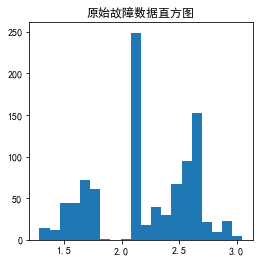

In [85]:
'''
原始故障数据直方图
'''
fig = plt.figure(figsize=(4,4))


plt.hist(w.re[w.flag==1],bins=20)
plt.title("原始故障数据直方图")
#fig.savefig("质量得分.jpg")

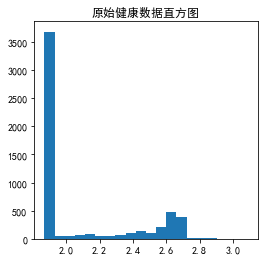

In [86]:
'''
原始健康数据直方图
'''
fig = plt.figure(figsize=(4,4))

plt.hist(w.re[w.flag==0],bins=20)
plt.title("原始健康数据直方图")
#fig.savefig("质量得分.jpg")


In [88]:
'''
重要的分位点
'''
print(np.percentile(w.re[w.flag==0],5) )   ####初始f1
print(np.percentile(w.re[w.flag==0],20))   ####初始警戒线
print(np.percentile(w.re[w.flag==0],99))   ####初始f2

1.8692651613788747
1.8692651613788747
2.7438027510995604


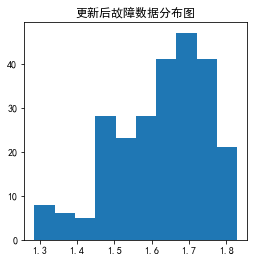

In [89]:
'''
更新后故障数据   
'''
fig = plt.figure(figsize=(4,4))
re_guzhang=w.re[w.flag==1]
plt.hist(re_guzhang[re_guzhang<np.percentile(w.re[w.flag==0],20)])
plt.title("更新后故障数据分布图")

#fig.savefig("质量得分.jpg")


In [90]:
'''
60分对应的质量得分
'''
f1=np.percentile(re_guzhang[re_guzhang<np.percentile(w.re[w.flag==0],20)],80)   ##最终f1
print(f1)

1.7336986328874375


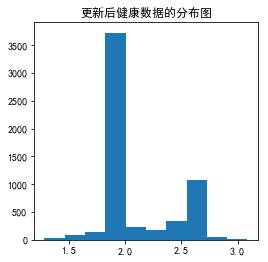

In [91]:
'''
更新后健康数据
'''
re_health=w.re[w.flag==0]
re_health=re_health.append(re_guzhang[re_guzhang<np.percentile(w.re[w.flag==0],20)])
fig = plt.figure(figsize=(4,4))


plt.hist(re_health)
plt.title("更新后健康数据的分布图")

fig.savefig("质量得分.jpg")

In [92]:
'''
70分对应质量得分

100分对应的最小质量得分
'''
警戒值=np.percentile(re_health,20)   ###最终警戒值
print(警戒值)
f2=np.percentile(re_health,99)  ###最终f2
print(f2)

1.8692651613788747
2.7286826585721937


## 计算单台设备的健康分数
上一步得到的3个转折点作为参数，输入新的数据，输出0-100的健康分数

In [93]:
'''
质量分数转化为0-100的健康分数
'''
def go_score(score,f1,警戒值,f2): 
    if score<=f1:
        score=60/f1*score
    else:
        if score<=警戒值:
            score=10/(警戒值-f1)*(score-f1)+60
        else:
            if score<=f2:
                score=30/(f2-警戒值)*(score-警戒值)+70
            else:
                score=100
    return score

In [95]:
%%time
newdata=pd.DataFrame(train_ax.iloc[1,:]).T
print("健康得分:",go_score(model.newdatahand(newdata,guzhang=True),f1=f1,警戒值=警戒值,f2=f2))

故障特征排序: Index(['GSMSIGNAL', 'LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES'], dtype='object')
健康得分: 100
Wall time: 352 ms


# 指定时间，指定设备号 的数据得分

In [96]:
'''
选取指定时间，制定设备的数据
'''
def gen_interval(data,y,UNIQUENO,start='2017-03-01',end='2018-10-12'):

    # 1.选数据
    # <1> 选设备
    data_unino = data[data.UNIQUENO==UNIQUENO].drop(columns=['UNIQUENO'])
    y_unino = y[y.UNIQUENO==UNIQUENO].drop(columns=['UNIQUENO'])

    # <2> 选时间片段
    data_date = data_unino[start:end]
    y_date = y_unino[start:end]
    data_date.sort_index(inplace=True)
    y_date.sort_index(inplace=True)
    return data_date,y_date

In [98]:
train_x,train_y=gen_interval(train_ax,train_ay,201707201730009538)

In [99]:
re=[]
for i in range(train_x.shape[0]):  
        re.append(go_score(model.newdatahand(pd.DataFrame(train_x.iloc[i,:]).T,guzhang=True),f1=f1,警戒值=警戒值,f2=f2))

故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSI

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSI

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCAT

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSI

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCAT

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCAT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCAT

故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSI

故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

In [100]:
re=pd.DataFrame(re)
re.index=train_x.index
re  ##得分

,0
COLLECTTIME,
2018-04-13 13:59:09,97.262387
2018-04-13 14:08:24,97.033600
2018-04-13 14:14:24,99.834578
2018-04-13 14:32:08,95.921107
2018-04-13 14:38:09,97.536936
2018-04-13 14:44:08,96.836734
2018-04-13 14:50:08,97.536936
2018-04-13 14:52:08,98.204147
2018-04-13 15:10:08,96.836734


# 历史得分画图

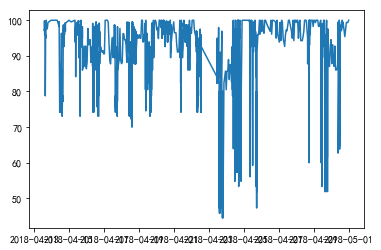

In [101]:
'''
单台设备的健康分数时序图
'''
plt.plot(re)   

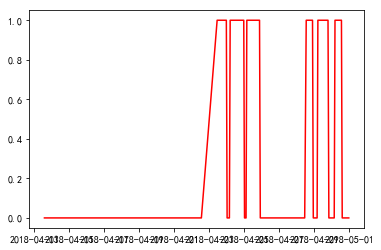

In [102]:
'''
单台设备是否故障时序图
'''
plt.plot(train_y, 'r')

# 设备分数排名
输入一段时间内所有设备的特征，输出所有设备的最大健康分数

In [103]:
"""start='2018-04-27 8:00:00',end='2018-04-27 9:00:00'      ,所有设备"""

"start='2018-04-27 8:00:00',end='2018-04-27 9:00:00'      ,所有设备"

In [104]:
UNIQUENO=train_ax.UNIQUENO     ###设备号
SCORE=pd.DataFrame(columns=set(UNIQUENO),index=["max"])  ###存储最大得分

In [105]:
for i in SCORE.columns:
    train_x,train_y=gen_interval(train_ax,train_ay,i,start='2018-04-27 8:00:00',end='2018-04-27 9:00:00')
    score_tem=np.zeros(train_x.shape[0])
    for j in range(train_x.shape[0]):
        
        score_tem[j]=go_score(model.newdatahand(pd.DataFrame(train_x.iloc[j,:]).T,guzhang=True),f1=f1,警戒值=警戒值,f2=f2)
    if len(score_tem)!=0:    
        SCORE[i]=np.max(score_tem)

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSI

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSI

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSI

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSI

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCAT

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSI

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSI

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSI

故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCAT

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSI

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['ACCRUNTIMES', 'LATITUDE', 'LOCATIONSTATE', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['ACCRU

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['ACCRUNTIMES', 'LATITUDE', 'LOCATIONSTATE', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSI

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSI

故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSI

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCAT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSI

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSI

故障特征排序: Index(['GSMSIGNAL', 'LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['ACCRUNTIMES', 'LATITUDE', 'LOCATIONSTATE', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['ACCRUNTIMES', 'LOCATIONSTATE', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['ACCRUNTIMES', 'LATITUDE', 'LOCATIONSTATE', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['ACCRUNTIMES', 'LATITUDE', 'LOCATIONSTATE', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSI

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCAT

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSI

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSI

故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'GSMSIGNAL', 'LATITUDE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'GSMSIGNAL', 'LATITUDE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'GSMSIGNAL', 'LATITUDE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'GSMSIGNAL', 'LATITUDE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'GSMSIGNAL', 'LATITUDE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCAT

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['ACCRUNTIMES', 'LOCATIONSTATE', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSI

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSI

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCAT

故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSI

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSI

故障特征排序: Index(['ACCRUNTIMES', 'LOCATIONSTATE', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['ACCRUNTIMES', 'LOCATIONSTATE', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['ACCRUNTIMES', 'LATITUDE', 'LOCATIONSTATE', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSI

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSI

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSI

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCAT

故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCAT

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'GSMSIGNAL', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATIT

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSI

故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LOCAT

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSI

故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LOCATIONSTATE', 'LATITUDE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSI

故障特征排序: Index(['ACCRUNTIMES', 'LATITUDE', 'LOCATIONSTATE', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['ACCRUNTIMES', 'LATITUDE', 'LOCATIONSTATE', 'GSMSIGNAL'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSIGNAL', 'LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES'], dtype='object')
故障特征排序: Index(['GSMSI

In [106]:
SCORE   #########最大健康分数

,201708151830161408,201612081130049541,201708151830161414,201612081130049543,201612081130049542,201610061830037520,201704151559596048,201803200928487444,201704151559596054,201803271428167702,...,201703301130045382,201703301130045381,201802062029586379,201705081505327059,201704181207476183,201601251130011620,201708261730041829,201609050830036980,201705101530077175,201803311428007931
max,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,79.891772,NaN,...,NaN,100.0,NaN,71.949193,NaN,100.0,100.0,86.943754,86.943754,NaN


# 设备分数排名

In [107]:
SCORE.fillna(0,inplace=True)
np.argsort(np.max(SCORE,axis=0))

201708151830161408      0
201612081130049541    575
201708151830161414    576
201612081130049543    577
201612081130049542    579
201610061830037520    581
201704151559596048    583
201803200928487444    584
201704151559596054    587
201803271428167702    574
201803200928487446    588
201705151007377433    592
201704151559596061    593
201804021927507998    596
201704151559596063    600
201701191730081825    602
201708010918309922    603
201804021927508004    606
201703281030025260    607
201803180928567346    589
201701231130021941    572
201701231130021942    570
201803271514267703    569
201701231130021944    538
201701231130021945    541
201612160830029882    542
201612160830029881    545
201612160830029883    546
201612160830029885    548
201612160830029886    549
                     ... 
201702031030022046    599
201804231226228639    233
201707020929589154    294
201707020929589155    215
201804231226228643    630
201803141629157285    632
201804272229328806    819
201702031030

In [108]:
UNIQUENO[np.argsort(np.max(SCORE,axis=0))].reset_index(drop=True)

0       201702251130053442
1       201701251030021984
2       201611230930029200
3       201612191330029978
4       201702251130053442
5       201702081330022189
6       201701061100251460
7       201702081330022189
8       201703191430034909
9       201701061100251460
10      201702150930022668
11      201703191430034909
12      201701061100251460
13      201701251030021984
14      201701131102051669
15      201701061057021457
16      201702251130053442
17      201701131102051669
18      201702141430012582
19      201702150930022668
20      201701131102051669
21      201701251030021984
22      201702081330022189
23      201702081330022189
24      201702251130053442
25      201702251130053442
26      201701061057021457
27      201702081330022189
28      201702081330022189
29      201702081330022189
               ...        
981     201701251030021984
982     201702081330022189
983     201703191430034909
984     201702150930022665
985     201701251030021984
986     201611230930029200
9